## Weather Temperature Forecasting


The objective of this demo is to develop a Recurrent Neural Network (RNN) model for temperature forecasting.

The dataset is available at: https://raw.githubusercontent.com/danrustia11/WeatherLSTM/master/data/weather_temperature_yilan.csv

The dataset contains daily temperature recordings of Yilan,Taiwan. 

The learning outcomes of this demo are: \\
1. Exploratory Data Analysis
2. Data Preparation
3. Model Development
4. Hyperparameter tuning 
5. K-Fold Cross Validation
6. Testing
7. Visualizing Results
8. Forecasting Temperature for Next 20 Days

In [54]:
#from google.colab import drive
#drive.mount('/content/drive')

In [55]:
# import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import sklearn
from scipy.ndimage import gaussian_filter1d       # Gaussian Filter

The pseudorandom number works by starting with an integer called a seed and then generates numbers in succession. The same seed gives the same sequence of random numbers, hence the name "pseudo" random number generation. If you want to have reproducible code, it is good to seed the random number generator using the np.random.seed() function.

Link: https://www.datacamp.com/community/tutorials/numpy-random

In [56]:
np.random.seed(1)
#random_numbers = np.random.random(size=4)
#random_numbers

In [57]:
tf.random.set_seed(1)
#random_numbers = tf.random.uniform(shape=[4])
#random_numbers

In [58]:
# we will download the dataset from the GitHub directly 
URL = "https://raw.githubusercontent.com/danrustia11/WeatherLSTM/master/data/weather_temperature_yilan.csv"
data = pd.read_csv(URL)

# Exploratory Data Analysis

In [59]:
# observe the first 5 samples from the dataset
data.head()

,Date,Temperature
0,2013/01/01,13.0
1,2013/01/02,20.0
2,2013/01/03,15.0
3,2013/01/04,15.0
4,2013/01/05,19.0


In [60]:
# get information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         2190 non-null   object 
 1   Temperature  2190 non-null   float64
dtypes: float64(1), object(1)
memory usage: 34.3+ KB


In [61]:
# print out the statistics of the dataset
data.describe()

,Temperature
count,2190.000000
mean,24.910046
std,5.953617
min,7.800000
25%,20.000000
50%,25.000000
75%,30.000000
max,36.000000


In [62]:
# Separate Date and Temperature from the dataframe "data" 
temp = data['Temperature']
date = data['Date']

Text(0.5, 1.0, 'Unfiltered Data')

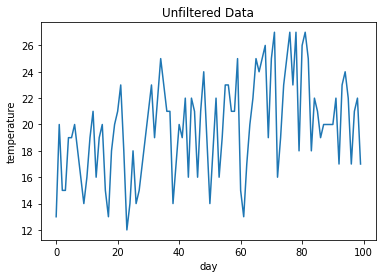

In [63]:
# plot the temperature with and without filtering
plt.figure()
plt.plot(temp[:100])  # plot only first 100 values for better visualization
plt.xlabel('day')
plt.ylabel('temperature')
plt.title("Unfiltered Data")

In [64]:
# filter the temperature values using a Gaussian filter with standard deviation (sigma) = 1
filtered_temp = gaussian_filter1d(temp.values,sigma = 1)

Text(0.5, 1.0, 'Filtered Data')

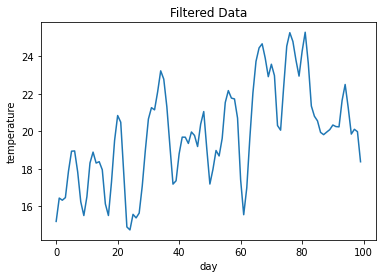

In [65]:
plt.figure()
plt.plot(filtered_temp[:100])
plt.xlabel('day')
plt.ylabel('temperature')
plt.title("Filtered Data")

# Data Preparation

In [67]:
# split the data into training and testing set 
n_train = 1500      # number of samples to use for training data
n_test = 500        # number of samples to use for test data

training_set = pd.DataFrame(filtered_temp[0:n_train])     # get first 1500 samples as training data
testing_set = pd.DataFrame(filtered_temp[n_train:n_train+n_test])   # get the next 500 samples as test data

In [ ]:
testing_set.head()

,0
0,14.874839
1,12.818810
2,12.526154
3,13.491234
4,15.368618


In [69]:
# scale the data to (0,1) using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# define an instance of MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))     # feature range = scale all input data to this range

# scale the training and testing set 
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.fit_transform(testing_set)

In [70]:
testing_set_scaled[:5]

array([[0.20238029],
       [0.11822657],
       [0.10624809],
       [0.14574904],
       [0.22259075]])

The dataset is in the form of a timeseries. In order to convert this data into a supervised dataset (input and output pair) we need to perform the following modification. We will use the previous 10 days' data to predict the next day's output.

For i=0,1,2,3...
  1. Set the temperature values from t=i to t=i+9 as input sample/sequence (X)
  2. Set the temperature value at t=i+10 as the true predicted temperature (y)

In [72]:
# define a function to convert series to supervised data
def data_split(sequence, n_timestamp):
    X = []    # define an empty list to store input values X
    y = []    # define an empty list to store output values y
    for i in range(len(sequence)-n_timestamp):    # loop through all the samples (subtract n_timestamp so that for the last loop, the output value is the last element of the sequence)
        end_ix = i + n_timestamp      # get the last index

        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]   # get the data in the required format
        X.append(seq_x)     # add the sequence to X
        y.append(seq_y)     # add the true output to y
    return np.array(X), np.array(y)   # return numpy array of X and y

In [74]:
# get the training and test input and output in the required format
n_timestamp = 10 # use previous n days' temperature to predict the next day's temperature
X_train, y_train = data_split(training_set_scaled, n_timestamp)
X_test, y_test = data_split(testing_set_scaled, n_timestamp)

In [76]:
print("input sequence: \n",X_train[0])
print("output:",y_train[0])

input sequence: 
 [[0.21301404]
 [0.26537985]
 [0.2605344 ]
 [0.26639045]
 [0.32536165]
 [0.37044179]
 [0.37101891]
 [0.32386353]
 [0.25698295]
 [0.2262176 ]]
output: [0.268683]


# Model Development

**Model Architecture:**

We will develop a LSTM model for the task of forecasting.

The LSTM layer can be added by using the command "tf.keras.layers.LSTM()". The arguments of the function are:
1. units = size of the hidden state (h) vector 
2. activation = activation function used inside the LSTM cell
3. return_sequences= Whether to return the last output in the output
sequence, or the full sequence. This is set to "True" when the model has more than one LSTM layers.

The output layer uses a Dense Network with 1 output neuron. 
We use the tf.keras.layers.Dense() function to add a Dense layer. The activation function used for the output layer is sigmoid. The input temperature values were scaled to (0,1), hence we want the output temperature values also in the same range.

In [77]:
# build the LSTM model

model = tf.keras.Sequential()   #create a Sequential model
model.add(tf.keras.layers.LSTM(units=50,activation='relu',return_sequences=True,input_shape=(X_train.shape[1], 1))) #Add LSTM layer
model.add(tf.keras.layers.LSTM(units=50,activation='relu'))   # Add LSTM layer
model.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))  # output dense layer.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


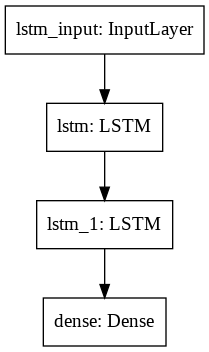

In [78]:
tf.keras.utils.plot_model(model)

**Configure and train the model**

We will use Adam as the optimizer. It can be defined by using the function tf.keras.optimizers.Adam(). The arguments are: \\
1. learning_rate = initial learning rate
2. beta_1 = 0.9 
3. beta_2 = 0.999
4. epsilon = 10^(-8) 

Since this is a regression problem, we will use the Mean Squared Error (MSE) as our loss function. 

The model is trained for 25 epochs with a batch size of 32.

In [79]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8) # define the optimizer
model.compile(optimizer = optimizer, loss = 'mean_squared_error')   
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs = 25, batch_size = 32)  # start the training process

Epoch 1/25
47/47 [==============================] - 1s 18ms/step - loss: 0.0581 - val_loss: 0.0353
Epoch 2/25
47/47 [==============================] - 1s 12ms/step - loss: 0.0199 - val_loss: 0.0153
Epoch 3/25
47/47 [==============================] - 1s 11ms/step - loss: 0.0120 - val_loss: 0.0120
Epoch 4/25
47/47 [==============================] - 1s 11ms/step - loss: 0.0113 - val_loss: 0.0113
Epoch 5/25
47/47 [==============================] - 1s 12ms/step - loss: 0.0104 - val_loss: 0.0109
Epoch 6/25
47/47 [==============================] - 1s 12ms/step - loss: 0.0096 - val_loss: 0.0098
Epoch 7/25
47/47 [==============================] - 1s 11ms/step - loss: 0.0094 - val_loss: 0.0096
Epoch 8/25
47/47 [==============================] - 1s 11ms/step - loss: 0.0089 - val_loss: 0.0106
Epoch 9/25
47/47 [==============================] - 1s 11ms/step - loss: 0.0083 - val_loss: 0.0084
Epoch 10/25
47/47 [==============================] - 1s 11ms/step - loss: 0.0084 - val_loss: 0.0080
Epoch 11/

# Hyperparameter Tuning

Methods of Hyperparameter tuning: \\
1. Manual Search
2. Grid Search
3. Random Search

We will use the manual search method to compare the performance of the model on different optimizers. \\
1. SGD
2. SGD + Momentum
3. Adam

In [80]:
optimizers = [tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.0),tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9),
              tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)]     # define a list of optimizers

history_list=[]   # define an empty list to store the results
for optimizer in optimizers:
  # build the model architecture
  model1 = tf.keras.Sequential()
  model1.add(tf.keras.layers.LSTM(units=50,activation='relu',return_sequences=True,input_shape=(X_train.shape[1], 1)))
  model1.add(tf.keras.layers.LSTM(units=50,activation='relu'))
  model1.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))
  
  # set the optimizer and loss function
  model1.compile(optimizer = optimizer, loss = 'mean_squared_error')
  
  # train the model on training and validation data
  history = model1.fit(X_train, y_train, validation_data=(X_test,y_test), epochs = 25, batch_size = 32, verbose=0)
  history_list.append(history)      # append the results to the list

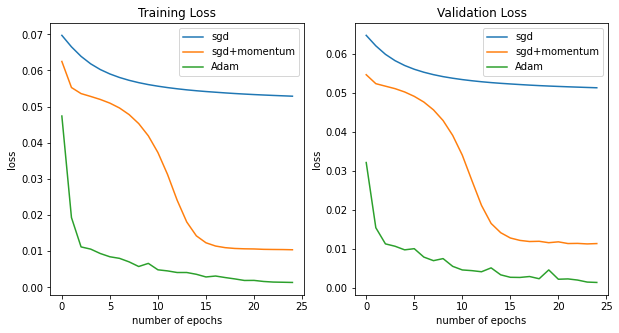

In [82]:
# plot the training and validation loss for all the optimizers

sgd = history_list[0]     
sgd_mom = history_list[1]
adam = history_list[2]

# plot for training loss
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(sgd.history['loss'],label='sgd')
plt.plot(sgd_mom.history['loss'],label='sgd+momentum')
plt.plot(adam.history['loss'],label='Adam')
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.title("Training Loss")
plt.legend()

# plot for validation loss
plt.subplot(1,2,2)
plt.plot(sgd.history['val_loss'],label='sgd')
plt.plot(sgd_mom.history['val_loss'],label='sgd+momentum')
plt.plot(adam.history['val_loss'],label='Adam')
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.title("Validation Loss")
plt.legend()

We will use the Grid Search method for finding the best set of hyperparameters.

The hyperparameters to tune are:
1. Number of LSTM layers (N)
2. LSTM cell activation function (A)
3. batch size (B)

The grid is of the form [ N,A,B]

In [84]:
from sklearn.metrics import r2_score

grid_list = [[1,'tanh',16],[2,'relu',32],[1,'relu',16],[1,'tanh',32]]   # define a grid of hyperparameters
R2_list=[]    # create an empty list to store all R2 values
for grid in grid_list:
  N = grid[0]   # number of LSTM layers
  A = grid[1]   # activation function
  B = grid[2]   # batch size

  # build the model architecture
  '''
  If the model has more than one LSTM layers, then we need to have the 'return_sequences' argument set as True for all but the last LSTM layer
  '''
  model1 = tf.keras.Sequential()
  if N==1:
      model1.add(tf.keras.layers.LSTM(units=50,activation=A))   # the length of the hidden state vector is 50
  else:
    for i in range(N-1):
      model1.add(tf.keras.layers.LSTM(units=50,activation=A,return_sequences=True))   # add LSTM layers with 'return_sequence' set as True
    
    model1.add(tf.keras.layers.LSTM(units=50,activation=A))     # the last LSTM layer
  
  model1.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))
  
  # set the optimizer and loss function
  model1.compile(optimizer = 'adam', loss = 'mean_squared_error')
  
  # train the model on training and validation data
  history = model1.fit(X_train, y_train, validation_data=(X_test,y_test), epochs = 25, batch_size = B, verbose=0)
  y_predicted = model1.predict(X_test)
  y_predicted_descaled = sc.inverse_transform(y_predicted)    # use MimMaxScaler's inverse transform function
  y_test_descaled = sc.inverse_transform(y_test)
  y_pred = y_predicted.ravel()        # ravel - convert from column format to row format
  y_pred = [round(yx, 2) for yx in y_pred]    # round off all values to two decimal points
  y_tested = y_test.ravel()

  score = r2_score(y_tested,y_pred)
  R2_list.append(score)


In [85]:
print("best grid of hyperparameters: \n")
print(grid_list[np.argmax(R2_list)])
print("R2 score:",np.max(R2_list))

best grid of hyperparameters: 

[2, 'relu', 32]
R2 score: 0.9497151399658986


# K-Fold Cross Validation

Cross Validation is a technique which involves reserving a particular sample of the dataset on which we do not train the model. 

This sample is called the validation set which is used to validate the performance of the trained model.

K-Fold Cross Validation is a cross validation technique in which the dataset is divided into K equal parts. In each iteration one part is reserved as the validation set and the remaining K-1 parts are used as training set.

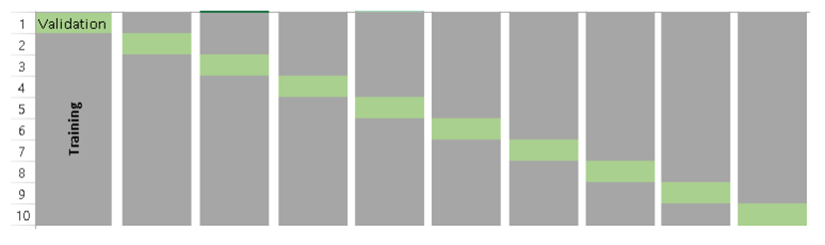

The overall performance of the model is equal to the average of the performance of the model on each validation set.

In [90]:
# combine the originally split train and test dataset to make 1 single dataset
X = np.vstack((X_train,X_test))   # vstack will stack one array below the other
y = np.vstack((y_train,y_test))

print("length of X: ",len(X))

length of X:  1980


In [91]:
# define a function that will build the required model
def baseline_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.LSTM(units=50,activation='relu',return_sequences=True,input_shape=(X_train.shape[1], 1)))
  model.add(tf.keras.layers.LSTM(units=50,activation='relu'))
  model.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))

  model.compile(loss='mse', optimizer='adam')
  return model

In [93]:
from sklearn.model_selection import KFold   # we will use the KFold function from the sklearn library
n_split=10      # define number of folds
Score_list =[]  # create an empty list to store the values

'''
KFold(n_split).split(X) - this function will return the indices of the elements that are part of the training set and the test set for every
iteration.
'''
for train_index,test_index in KFold(n_split).split(X):    #run the loop for n folds
  print("training dataset indices:",train_index)          # print the indices included in the training set for the current fold
  print("testing dataset indices",test_index)             # print the indices included in the testing set for the current fold
  x_train,x_test=X[train_index],X[test_index]             # split the dataset(samples) in training and testing
  Y_train,Y_test=y[train_index],y[test_index]             # split the dataset(output) into training and testing
  
  model1=baseline_model()            # build the model
  model1.fit(x_train, Y_train,epochs=20,batch_size=32,verbose=0)   #train the model
  y_pred = model.predict(x_test)    # predict output for test data

  score =r2_score(Y_test,y_pred)    # get R2 score
  print("R2 score: ",score)
  Score_list.append(score)          # add R2 score to the list

R2 score:  0.9418579625081721
R2 score:  0.97108727751612
R2 score:  0.9588369292632739
R2 score:  0.9624277415605144
R2 score:  0.9122836499729887
R2 score:  0.9163507016887912
R2 score:  0.8569055774744758
R2 score:  0.8759975365646859
R2 score:  0.9385598091165
R2 score:  0.9413468743602611


In [ ]:
Overall_R2 = np.mean(Score_list)
print("Overall R2 score after K-Fold CV: ",Overall_R2)

Overall R2 score after K-Fold CV:  0.9275654060025783


# Testing

The model is tested on the originally split test set containing 500 samples. 

In [ ]:
# predict the temperature
y_predicted = model.predict(X_test)

De-normalize the output to get temperature values

We will convert back the temperature values from (0,1) to the original range. To do this we will use the "MinMaxScaler.inverse_transform" function

In [ ]:
y_predicted_descaled = sc.inverse_transform(y_predicted)    # use MimMaxScaler's inverse transform function
y_train_descaled = sc.inverse_transform(y_train)
y_test_descaled = sc.inverse_transform(y_test)
y_pred = y_predicted.ravel()        # ravel - convert from column format to row format
y_pred = [round(yx, 2) for yx in y_pred]    # round off all values to two decimal points
y_tested = y_test.ravel()

# Results

**Training and Validation Loss**

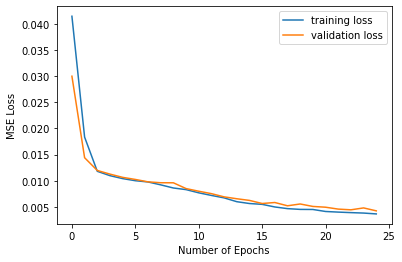

In [ ]:
# Loss 
plt.plot(history.history['loss'],label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel("MSE Loss")
plt.legend()

**Output Visualization**

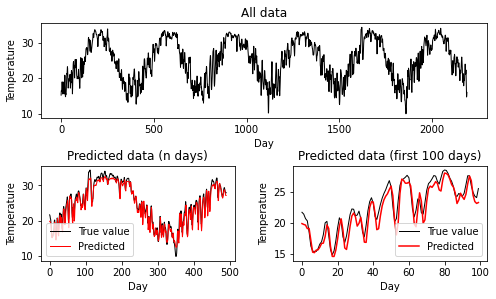

In [ ]:
plt.figure(figsize=(8,7))

# plot the entire timeseries
plt.subplot(3, 1, 1)
plt.plot(filtered_temp, color = 'black', linewidth=1, label = 'True value')
plt.ylabel("Temperature")
plt.xlabel("Day")
plt.title("All data")

# plot the testing data and the predicted values of temperature
plt.subplot(3, 2, 3)
plt.plot(y_test_descaled, color = 'black', linewidth=1, label = 'True value')   # training temeperature data
plt.plot(y_predicted_descaled, color = 'red',  linewidth=1, label = 'Predicted')  # predicted data
plt.legend()
plt.ylabel("Temperature")
plt.xlabel("Day")
plt.title("Predicted data (n days)")

# plot only the first 100 testing data for better visualization
plt.subplot(3, 2, 4)
plt.plot(y_test_descaled[0:100], color = 'black', linewidth=1, label = 'True value')  # training temeperature data
plt.plot(y_predicted_descaled[0:100], color = 'red', label = 'Predicted')  # predicted data
plt.legend()
plt.ylabel("Temperature")
plt.xlabel("Day")
plt.title("Predicted data (first 100 days)")

plt.subplots_adjust(hspace = 0.5, wspace=0.3)   # adjust the subplots to keep space between them
plt.show()

# Forecasting temperature 

Now we will predict the the temperature for the next 20 days using the trained model. There is a slight difference between the testing and forecasting the values. 

In testing we use the true values of the input sequence in order to predict the temperature for the next day. 

However in forecasting, we do not have true temperature values for the 20 days in the future. For prediction of each day in the future, we make use of the temperature values predicted for the previous days.

The input for each day will be the temperature of the 10 previous days.

In [94]:
new_filtered_temp = filtered_temp.copy()    # create a copy to avoid tampering with the original dataset
for i in range(20):   #run the loop 20 times 
  input = pd.DataFrame(new_filtered_temp[-10:]) # get the last 10 values as the input
  scaled_input = sc.fit_transform(input)    # scale the input
  output = model.predict(scaled_input.reshape(1,scaled_input.shape[0],scaled_input.shape[1]))   # need to reshape the input according to the format accepted by TensorFlow
  output = sc.inverse_transform(output)       # denormalize the output to get the temperature values
  new_filtered_temp = np.append(new_filtered_temp,output)     # add the temeprature value to the temperature list..

Plot the Results

The plot in black is the true temperature of past 90 days measured by a sensor. The plot in red is the predicted value of the temperature for the next 20 days.

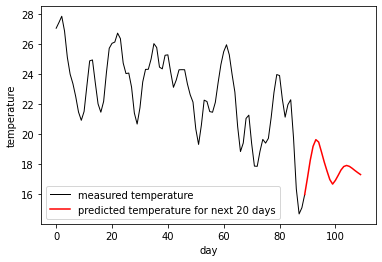

In [96]:
t = range(len(new_filtered_temp[2100:]))    # define x-axis for plotting
plt.plot(t[0:90],new_filtered_temp[2100:2190], color = 'black', linewidth=1,label='measured temperature') # plot the measured temperatures
plt.plot(t[89:],new_filtered_temp[2189:],color = 'red',label='predicted temperature for next 20 days')    # plot the predicted temperatures
plt.xlabel('day')
plt.ylabel("temperature")
plt.legend()